In [235]:
from keras.utils import to_categorical
from keras import layers
from keras import models
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
import pandas as pd
from keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score 

### Loading Data into Data Frame

In [200]:
# loading Meta data csv
Meta_df = pd.read_csv('../German_Traffic_Sign_Classification/gtsrb-german-traffic-sign/Meta.csv')
print(Meta_df.shape)

(43, 5)


In [78]:
# loading test data csv
df = pd.read_csv('gtsrb-german-traffic-sign/test.csv')

# ClassId identifies the photo class
test_df = list(df['ClassId'].astype('str'))
df['ClassId'] = df['ClassId'].astype('str')

In [201]:
# Loading train data csv
train_df = pd.read_csv('../German_Traffic_Sign_Classification/gtsrb-german-traffic-sign/Train.csv')
print(train_df.shape)
train_df.info()

(39209, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
Width      39209 non-null int64
Height     39209 non-null int64
Roi.X1     39209 non-null int64
Roi.Y1     39209 non-null int64
Roi.X2     39209 non-null int64
Roi.Y2     39209 non-null int64
ClassId    39209 non-null int64
Path       39209 non-null object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


### Load Images

In [41]:
# df = pd.read_csv('Test.csv')
# # # df['ClassId'].sort_values(ascending=True).unique()
# df.head()

In [202]:
# Path directories for  train and test images
train_data_dir = '../German_Traffic_Sign_Classification/gtsrb-german-traffic-sign/Train'
test_data_dir = '../German_Traffic_Sign_Classification/gtsrb-german-traffic-sign/Test_2'

In [134]:
# Generating images from Directories
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(64, 64),
        classes =  [str(i) for i in np.arange(43)], 
        batch_size=39209)

# for test_generator, we use .flow_from_database to ensure that labels correspond to images.
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe= df,
        directory= test_data_dir,
        x_col= 'Path',
        y_col = 'ClassId',
        target_size=(64, 64),
        batch_size=12630,
        classes= test_df,
        class_mode='raw')
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 39209 images belonging to 43 classes.


/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:211: UserWarning: `classes` will be ignored given the class_mode="raw"
  .format(self.class_mode))


Found 12630 validated image filenames.


### Reshaping Data
Clarify why reshaping wasn't necessary

In [135]:
train_labels = np.array([list(img).index(1.0) for img in train_labels])
train_labels= to_categorical(train_labels)
test_labels= to_categorical(test_labels)

Image data and label data now have the same shape.

In [203]:
train_labels.shape

(39209, 43)

In [140]:
print(train_df.shape)
print(df.shape)

(39209, 8)
(12630, 8)


In [100]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [113]:
train_df.iloc[100]

Width                                  43
Height                                 41
Roi.X1                                  5
Roi.Y1                                  6
Roi.X2                                 38
Roi.Y2                                 36
ClassId                                20
Path       Train/20/00020_00003_00010.png
Name: 100, dtype: object

In [117]:
list(train_labels[100]).index(1.)

16

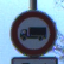

In [110]:
array_to_img(train_images[100])

Test images match test labels;

In [118]:
# #  properly sequencing label names
# path_test = [int(i.replace('Test/','').replace('.png','')) for i in test_df['Path']]
# id_test = list(test_df['ClassId'])
# path_id = dict(zip(path_test, id_test))
# labels = [path_id[batch] for batch in list(test_generator.index_array)]
# labels_numpy = np.array(labels)

In [119]:
# print(labels_numpy[35])
# array_to_img(test_images[35])


In [120]:
# def to_one_hot(labels, dimension=43):
#     labels = labels.astype('int32')
#     results = np.zeros((len(labels), dimension))
#     for i, label in enumerate(labels):
#         results[i, label] = 1.
#     return results

# # Our vectorized training labels
# one_hot_train_labels = to_one_hot(train_labels)
# # Our vectorized test labels
# one_hot_test_labels = to_one_hot(test_labels)

In [121]:
# one_hot_train_labels.shape

(39209, 43)

In [122]:
# one_hot_test_labels.shape

(12630, 43)

In [123]:
train_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Network Design
### 1st model implementing Keras Sequential model

In [142]:
# implemented without tuning such as dropout or padding data
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))


In [143]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)             

### Training first model
Optimized using rmsprop

In [131]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, one_hot_train_labels, epochs=5, batch_size=500)

Epoch 1/5
39209/39209 [==============================] - 412s 11ms/step - loss: 12303521.0647 - accuracy: 0.4617
Epoch 2/5
39209/39209 [==============================] - 416s 11ms/step - loss: 127552680.2070 - accuracy: 0.4480
Epoch 3/5
39209/39209 [==============================] - 351s 9ms/step - loss: 530290101.1828 - accuracy: 0.4587
Epoch 4/5
39209/39209 [==============================] - 336s 9ms/step - loss: 1494800323.7021 - accuracy: 0.4732
Epoch 5/5
39209/39209 [==============================] - 511s 13ms/step - loss: 3406941958.7050 - accuracy: 0.4771


In [132]:
test_loss, test_acc = model.evaluate(test_images, one_hot_test_labels)

12630/12630 [==============================] - 34s 3ms/step


In [133]:
test_acc

0.0

In [22]:
from keras.models import load_model
model.save('rmsprop_mod_1.h5')
# my_model = load_model('file_name_0f_your_model.h5')

# make predictions using your model 
# my_prediction = my_model.predict(x_test)

The poor accuracy resulted from using the wrong label set. 
Running a second model, this time using "Adam" as the optimizer.

### Second Model compiled using 'adam' optimizer

In [144]:
# second model using adam
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=500)

Epoch 1/5
39209/39209 [==============================] - 374s 10ms/step - loss: 2.7031 - accuracy: 0.3142
Epoch 2/5
39209/39209 [==============================] - 352s 9ms/step - loss: 0.7538 - accuracy: 0.7837
Epoch 3/5
39209/39209 [==============================] - 420s 11ms/step - loss: 0.2394 - accuracy: 0.9368
Epoch 4/5
39209/39209 [==============================] - 414s 11ms/step - loss: 0.1329 - accuracy: 0.9657
Epoch 5/5
39209/39209 [==============================] - 400s 10ms/step - loss: 0.0816 - accuracy: 0.9798


In [146]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss)
print(test_acc)

12630/12630 [==============================] - 35s 3ms/step
0.47693141494138036
0.9054631590843201


In [147]:
model.save('adam_mod_1.h5')

### Predictions- second model

In [150]:
from keras.models import load_model

In [191]:
 my_model = load_model('adam_mod_1.h5')
# make predictions using your model 
 my_prediction = my_model.predict(test_images)

In [192]:
my_prediction

array([[0.0000000e+00, 4.2077037e-36, 3.6618818e-38, ..., 3.7774335e-29,
        3.6172395e-34, 4.9094271e-20],
       [4.3449734e-18, 2.3209915e-17, 8.5943519e-13, ..., 1.4547279e-19,
        7.4893244e-13, 1.9990798e-10],
       [1.6157329e-18, 1.1970322e-13, 1.2077078e-09, ..., 1.1161073e-18,
        1.6610862e-11, 6.4096645e-07],
       ...,
       [1.4930434e-13, 1.7897577e-08, 2.0506158e-02, ..., 7.6469791e-23,
        5.5427982e-22, 1.4325473e-20],
       [6.3589619e-06, 2.7764793e-03, 1.5034620e-04, ..., 1.5868594e-06,
        2.0899591e-08, 3.3003136e-08],
       [1.5778490e-10, 4.7968376e-07, 2.3314721e-04, ..., 1.1672752e-15,
        1.2216923e-11, 1.3521096e-11]], dtype=float32)

Checking F-1 score for balance between Precision and Recall

In [190]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
# predictions_transfer = model.predict(test_images)
my_prediction = np.around(my_prediction)
f1_score = f1_score(test_labels, my_prediction, average='micro')
print('f1 score: {}'.format(f1_score))

f1 score: 0.9071288161431379


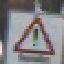

In [186]:
array_to_img(test_images[3])

Converting my_prediction array into a list of predictions for each image:

In [193]:
# test_prob = [np.argmax(i) for i in list(test_labels)]
# test_prob

In [176]:
wrong_preds = []
for i in range(len(test_labels)):
    if np.argmax(test_labels[i]) ==  np.argmax(my_prediction[i]):
        continue
    else:
        wrong_preds.append(i)

wrong_preds

[6,
 9,
 16,
 17,
 21,
 30,
 33,
 37,
 41,
 53,
 65,
 69,
 84,
 91,
 94,
 100,
 109,
 120,
 136,
 138,
 147,
 167,
 169,
 173,
 174,
 180,
 187,
 213,
 218,
 227,
 241,
 245,
 249,
 272,
 275,
 307,
 336,
 337,
 342,
 343,
 361,
 410,
 437,
 439,
 446,
 447,
 459,
 462,
 467,
 470,
 477,
 511,
 523,
 526,
 534,
 543,
 546,
 553,
 556,
 567,
 568,
 573,
 588,
 594,
 612,
 637,
 639,
 641,
 646,
 718,
 733,
 758,
 768,
 773,
 774,
 801,
 814,
 822,
 835,
 849,
 860,
 903,
 913,
 914,
 918,
 920,
 924,
 943,
 959,
 966,
 978,
 997,
 999,
 1007,
 1046,
 1066,
 1076,
 1080,
 1116,
 1149,
 1156,
 1163,
 1178,
 1193,
 1204,
 1226,
 1227,
 1260,
 1274,
 1275,
 1280,
 1296,
 1297,
 1328,
 1346,
 1349,
 1353,
 1371,
 1377,
 1385,
 1393,
 1394,
 1396,
 1399,
 1400,
 1402,
 1403,
 1413,
 1416,
 1421,
 1425,
 1472,
 1474,
 1481,
 1506,
 1507,
 1524,
 1532,
 1548,
 1553,
 1554,
 1560,
 1582,
 1595,
 1613,
 1616,
 1631,
 1644,
 1647,
 1659,
 1672,
 1676,
 1684,
 1685,
 1713,
 1719,
 1729,
 1740,
 174

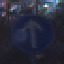

In [189]:
array_to_img(test_images[6])

### Third model- after tuning using padding and adding dropouts 

In [207]:
# implemented with tuning by adding dropouts between convolutions and padding data
model = models.Sequential()

# padding added to each convolution layer
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))

# using dropout of .1
model.add(layers.Dropout(0.1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))



In [210]:
# third model, 2nd using adam
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
x_val = train_images[:3000]
partial_x_train = train_images[3000:]
y_val = train_labels[:3000]
partial_y_train = train_labels[3000:]
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=500,
                    validation_data=(x_val, y_val))

Train on 36209 samples, validate on 3000 samples
Epoch 1/5
36209/36209 [==============================] - 238s 7ms/step - loss: 0.0822 - accuracy: 0.9788 - val_loss: 0.0548 - val_accuracy: 0.9880
Epoch 2/5
36209/36209 [==============================] - 239s 7ms/step - loss: 0.0268 - accuracy: 0.9928 - val_loss: 0.0556 - val_accuracy: 0.9867
Epoch 3/5
36209/36209 [==============================] - 265s 7ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.0423 - val_accuracy: 0.9887
Epoch 4/5
36209/36209 [==============================] - 276s 8ms/step - loss: 0.0131 - accuracy: 0.9963 - val_loss: 0.0365 - val_accuracy: 0.9910
Epoch 5/5
36209/36209 [==============================] - 229s 6ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 0.0551 - val_accuracy: 0.9847


In [225]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss)
print('Test accuracy: {}'.format(test_acc))

12630/12630 [==============================] - 16s 1ms/step
0.6940762542070186
Test accuracy: 0.8934283256530762


In [226]:
model.save('adam_mod_2.h5')

### Predictions for adam model 2

In [227]:
 my_model = load_model('adam_mod_2.h5')
# make predictions using your model 
 my_prediction = my_model.predict(test_images)

In [213]:
my_prediction

array([[3.05499447e-33, 1.29110576e-26, 1.11961734e-31, ...,
        9.27711633e-22, 2.47681450e-18, 5.28752542e-18],
       [4.35089631e-22, 2.61143685e-19, 2.30089266e-14, ...,
        1.58135228e-17, 4.33178409e-15, 1.08744483e-15],
       [5.38439447e-18, 3.68866092e-12, 1.75118953e-06, ...,
        1.46516862e-14, 2.03945229e-11, 2.53593182e-08],
       ...,
       [1.05583192e-13, 5.69099455e-11, 1.07746244e-04, ...,
        2.79698882e-17, 3.34640138e-21, 1.58022805e-13],
       [5.30063069e-08, 4.99583984e-06, 4.88168212e-07, ...,
        3.41639472e-09, 8.04371625e-14, 4.13564932e-10],
       [4.10353262e-12, 3.15710736e-07, 1.85150132e-02, ...,
        8.96639961e-18, 2.26282556e-12, 1.17551535e-09]], dtype=float32)

In [229]:
my_prediction = np.around(my_prediction)
f1_score = f1_score(test_labels, my_prediction, average='micro')
print('f1 score: {}'.format(f1_score))

TypeError: 'numpy.float64' object is not callable

### Visualizations for Adam model 2

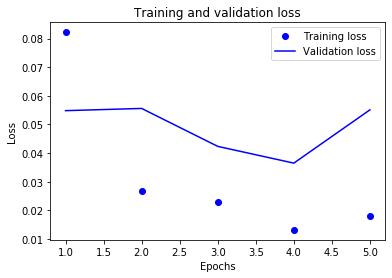

In [232]:
# visualizing Training and validation loss
loss = history.history['loss']
value_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, value_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

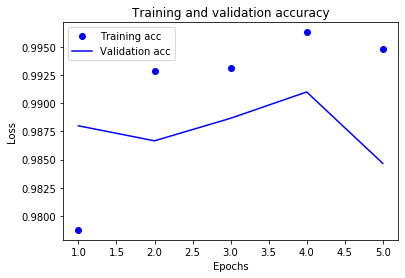

In [233]:
# visualizing training and validation accuracy
plt.clf()   # clear figure

acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Fourth Model- Adam with Nesterov Momentum

In [236]:
# implemented with tuning by adding dropouts between convolutions and padding data
model = models.Sequential()

# padding added to each convolution layer
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))

# using dropout of .1
model.add(layers.Dropout(0.1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))



In [237]:
# fourth model, 1st using Nadam
model.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
x_val = train_images[:3000]
partial_x_train = train_images[3000:]
y_val = train_labels[:3000]
partial_y_train = train_labels[3000:]
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=500,
                    validation_data=(x_val, y_val))

Train on 36209 samples, validate on 3000 samples
Epoch 1/5
36209/36209 [==============================] - 268s 7ms/step - loss: 2.6933 - accuracy: 0.2866 - val_loss: 1.7873 - val_accuracy: 0.5350
Epoch 2/5
36209/36209 [==============================] - 265s 7ms/step - loss: 0.9236 - accuracy: 0.7280 - val_loss: 0.4556 - val_accuracy: 0.8683
Epoch 3/5
36209/36209 [==============================] - 286s 8ms/step - loss: 0.2519 - accuracy: 0.9280 - val_loss: 0.1763 - val_accuracy: 0.9543
Epoch 4/5
36209/36209 [==============================] - 256s 7ms/step - loss: 0.0992 - accuracy: 0.9746 - val_loss: 0.1613 - val_accuracy: 0.9577
Epoch 5/5
36209/36209 [==============================] - 254s 7ms/step - loss: 0.0509 - accuracy: 0.9872 - val_loss: 0.1354 - val_accuracy: 0.9600


In [238]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss)
print('Test accuracy: {}'.format(test_acc))

12630/12630 [==============================] - 19s 1ms/step
0.43556216644655593
Test accuracy: 0.8851940035820007


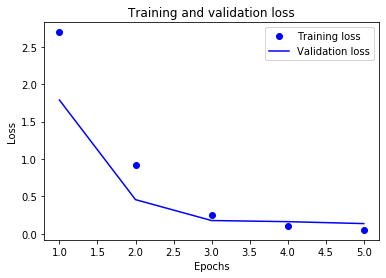

In [243]:
# visualizing Training and validation loss
loss = history.history['loss']
value_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, value_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

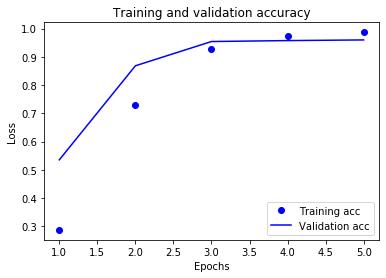

In [244]:
# visualizing training and validation accuracy
plt.clf()   # clear figure

acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [241]:
model.save('adam_mod_3.h5')

In [242]:
my_model = load_model('adam_mod_3.h5')
# make predictions using your model 
my_prediction = my_model.predict(test_images)

### Fifth Model- Adam with Nesterov Momentum, Increasing Dropout percentage

In [246]:
# implemented with tuning by adding dropouts between convolutions and padding data
model = models.Sequential()

# padding added to each convolution layer
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))

# increasing dropout from .1 to .3
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))

In [247]:
# Fifth model, 2nd using Nadam
model.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
x_val = train_images[:3000]
partial_x_train = train_images[3000:]
y_val = train_labels[:3000]
partial_y_train = train_labels[3000:]
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=500,
                    validation_data=(x_val, y_val))

Train on 36209 samples, validate on 3000 samples
Epoch 1/5
36209/36209 [==============================] - 244s 7ms/step - loss: 2.5620 - accuracy: 0.3307 - val_loss: 1.6060 - val_accuracy: 0.5560
Epoch 2/5
36209/36209 [==============================] - 227s 6ms/step - loss: 0.8581 - accuracy: 0.7394 - val_loss: 0.5054 - val_accuracy: 0.8877
Epoch 3/5
36209/36209 [==============================] - 237s 7ms/step - loss: 0.2724 - accuracy: 0.9213 - val_loss: 0.2276 - val_accuracy: 0.9513
Epoch 4/5
36209/36209 [==============================] - 225s 6ms/step - loss: 0.1088 - accuracy: 0.9705 - val_loss: 0.1668 - val_accuracy: 0.9687
Epoch 5/5
36209/36209 [==============================] - 276s 8ms/step - loss: 0.0648 - accuracy: 0.9833 - val_loss: 0.1403 - val_accuracy: 0.9790


In [249]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss)
print('Test accuracy: {}'.format(test_acc))

12630/12630 [==============================] - 19s 1ms/step
0.39781074462575
Test accuracy: 0.9005542397499084


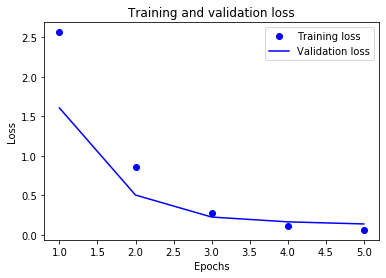

In [250]:
# visualizing Training and validation loss
loss = history.history['loss']
value_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, value_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

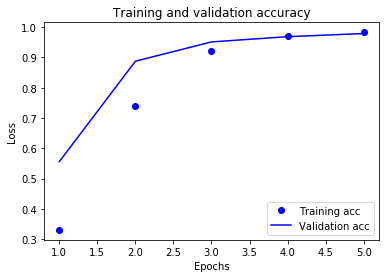

In [251]:
# visualizing training and validation accuracy
plt.clf()   # clear figure

acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [252]:
model.save('Nadam_mod_4.h5')

### Sixth Model- compiled using a smaller batch size of 250

In [254]:
# implemented with tuning by adding dropouts between convolutions and padding data
model = models.Sequential()

# padding added to each convolution layer
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))

# increasing dropout from .1 to .3
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))

In [255]:
# Fifth model, 2nd using Nadam
model.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
x_val = train_images[:3000]
partial_x_train = train_images[3000:]
y_val = train_labels[:3000]
partial_y_train = train_labels[3000:]
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=250,
                    validation_data=(x_val, y_val))

Train on 36209 samples, validate on 3000 samples
Epoch 1/5
36209/36209 [==============================] - 247s 7ms/step - loss: 1.8689 - accuracy: 0.4912 - val_loss: 0.6665 - val_accuracy: 0.8480
Epoch 2/5
36209/36209 [==============================] - 250s 7ms/step - loss: 0.3248 - accuracy: 0.9073 - val_loss: 0.2864 - val_accuracy: 0.9590
Epoch 3/5
36209/36209 [==============================] - 260s 7ms/step - loss: 0.1270 - accuracy: 0.9643 - val_loss: 0.1382 - val_accuracy: 0.9777
Epoch 4/5
36209/36209 [==============================] - 226s 6ms/step - loss: 0.0729 - accuracy: 0.9789 - val_loss: 0.1060 - val_accuracy: 0.9800
Epoch 5/5
36209/36209 [==============================] - 216s 6ms/step - loss: 0.0492 - accuracy: 0.9856 - val_loss: 0.0825 - val_accuracy: 0.9860


In [256]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss)
print('Test accuracy: {}'.format(test_acc))

12630/12630 [==============================] - 21s 2ms/step
0.2921106059638074
Test accuracy: 0.9210609793663025


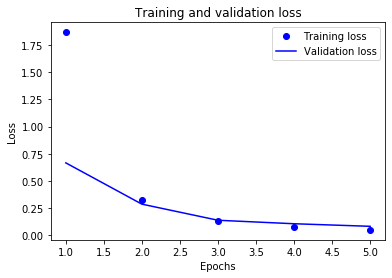

In [257]:
# visualizing Training and validation loss
loss = history.history['loss']
value_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, value_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

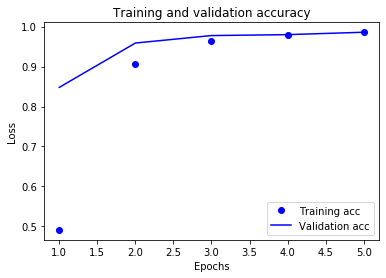

In [258]:
# visualizing training and validation accuracy
plt.clf()   # clear figure

acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
model.save('Nadam_mod_5.h5')

### Seventh Model

In [259]:
# implemented with tuning by adding dropouts between convolutions and padding data
model = models.Sequential()

# padding added to each convolution layer
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))

# dropout =  .3
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(43, activation='softmax'))

In [263]:
# Fifth model, 2nd using Nadam
model.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
x_val = train_images[:3000]
partial_x_train = train_images[3000:]
y_val = train_labels[:3000]
partial_y_train = train_labels[3000:]
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=250,
                    validation_data=(x_val, y_val))

Train on 36209 samples, validate on 3000 samples
Epoch 1/20
36209/36209 [==============================] - 230s 6ms/step - loss: 1.7911 - accuracy: 0.5137 - val_loss: 0.5459 - val_accuracy: 0.8810
Epoch 2/20
36209/36209 [==============================] - 228s 6ms/step - loss: 0.2215 - accuracy: 0.9361 - val_loss: 0.1891 - val_accuracy: 0.9697
Epoch 3/20
36209/36209 [==============================] - 219s 6ms/step - loss: 0.0790 - accuracy: 0.9772 - val_loss: 0.1463 - val_accuracy: 0.9830
Epoch 4/20
36209/36209 [==============================] - 211s 6ms/step - loss: 0.0549 - accuracy: 0.9841 - val_loss: 0.1040 - val_accuracy: 0.9807
Epoch 5/20
36209/36209 [==============================] - 225s 6ms/step - loss: 0.0343 - accuracy: 0.9900 - val_loss: 0.0755 - val_accuracy: 0.9857
Epoch 6/20
36209/36209 [==============================] - 208s 6ms/step - loss: 0.0224 - accuracy: 0.9932 - val_loss: 0.0652 - val_accuracy: 0.9860
Epoch 7/20
36209/36209 [==============================] - 229s 

In [264]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_loss)
print('Test accuracy: {}'.format(test_acc))

12630/12630 [==============================] - 23s 2ms/step
0.23801624321291018
Test accuracy: 0.9411718249320984


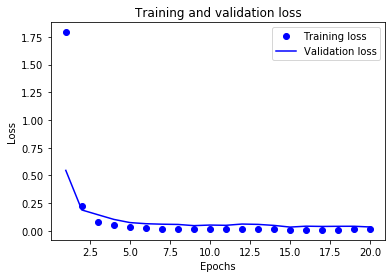

In [265]:
# visualizing Training and validation loss
loss = history.history['loss']
value_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, value_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

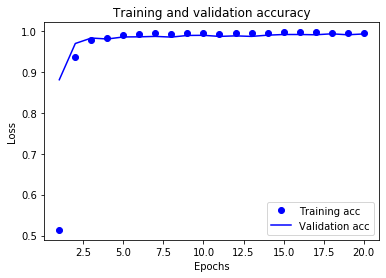

In [266]:
# visualizing training and validation accuracy
plt.clf()   # clear figure

acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [267]:
model.save('Nadam_mod_6.h5')

### Performance Evaluation